# シュレッダー復元問題の定式化

## 二次割当て問題としての定式化

### 定数とインデックス

- $N$: 紙片の総数
- $i,j \in [1,\dots,N]$: 位置を表すインデックス
- $a,b \in [1,\dots,N]$: 紙片を表すインデックス
- $d \in \{r, c\}$: 連結の方向
- $S_{abd}$: 紙片 $a$ と $b$ が方向 $d$ で連結した場合の類似度
- $D_{ijd}$: 位置 $i$ と $j$ が方向 $d$ でつながっているか否かのフラグ

### 変数

- $x_{ia}$: 位置 $i$ に紙片 $a$ が置かれている場合は $1$ となるフラグ

### 目的関数

$$
\max \sum_{abijd}S_{abd}D_{ijd}x_{ia}x_{jb}
$$

### 制約条件

- $\sum_{i}x_{ia} = 1$: 紙片 $a$ は、どこか一箇所にしか置かれない
- $\sum_{a}x_{ia} = 1$: 位置 $i$ における紙片は、1つである


## MIP への変形

$x_{ia}x_{jb}$を表す補助変数 $y_{ijab}$ を導入する

|$x_{ai}$|$x_{jb}$|$y_{ijab}$|
|:--:|:--:|:--:|
|0|0|0|
|0|1|0|
|1|0|0|
|1|1|1|

これは以下の制約で実現できる

- $x_{ia} + x_{jb} \leq y_{ijab} + 1$
- $x_{ia} \geq y_{ijab}$
- $x_{jb} \geq y_{ijab}$


In [1]:
from collections import defaultdict
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pulp
import time

In [2]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)

data = load_data('../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl')

In [3]:
def load_data(path):
    with open(path, 'rb') as i_:
        return pickle.load(i_)


def imshow(images, rows, cols):
    fig = plt.figure()
    for i, image in enumerate(images):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.axis('off')
        ax.imshow(image)
    fig.show()

In [4]:
def sim_x(left, right):
    shape = np.min((left.shape, right.shape), axis=0)
    return (left[:shape[0], -1] == right[:shape[0], 0]).sum()

def sim_y(up, down):
    shape = np.min((up.shape, down.shape), axis=0)
    return (up[-1, :shape[1]] == down[0, :shape[1]]).sum()

In [5]:
def build_model(data):
    model = pulp.LpProblem(sense=pulp.LpMinimize)
    x = np.array(pulp.LpVariable.matrix(
        'x',
        (range(data.size), range(data.rows), range(data.cols)),
        cat=pulp.LpBinary
    ))
    y = {}

    costs = []
    for a in range(data.size):
        img_a = data.images[a]
        for b in range(data.size):
            if a == b:
                continue
            img_b = data.images[b]
            sim = (sim_y(img_a, img_b), sim_x(img_a, img_b))
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        y[a, b, row, col, row + 1, col] = pulp.LpVariable(
                            f'y_{a}_{b}_{row}_{col}_{row + 1}_{col}',
                            cat=pulp.LpBinary
                        )
                        costs.append(-sim[0]*y[a, b, row, col, row + 1, col])
                    if col < data.cols - 1:
                        y[a, b, row, col, row, col + 1] = pulp.LpVariable(
                            f'y_{a}_{b}_{row}_{col}_{row}_{col + 1}',
                            cat=pulp.LpBinary
                        )
                        costs.append(-sim[1]*y[a, b, row, col, row, col + 1])
    model.setObjective(pulp.lpSum(costs))


    for a in range(data.size):
        for b in range(data.size):
            if a == b:
                continue
            for row in range(data.rows):
                for col in range(data.cols):
                    if row < data.rows - 1:
                        model.addConstraint(
                            x[a, row, col] >= y[a, b, row, col, row + 1, col]
                        )
                        model.addConstraint(
                            x[b, row + 1, col] >= y[a, b, row, col, row + 1, col]
                        )
                    if col < data.cols - 1:
                        model.addConstraint(
                            x[a, row, col] >= y[a, b, row, col, row, col + 1]
                        )
                        model.addConstraint(
                            x[b, row, col + 1] >= y[a, b, row, col, row, col + 1]
                        )

    for a in range(data.size):
        model.addConstraint(
            x[a].sum() == 1
        )

    for row in range(data.rows):
        for col in range(data.cols):
            model.addConstraint(
                x[:, row, col].sum() == 1
            )

    return model, x

model, x = build_model(data)

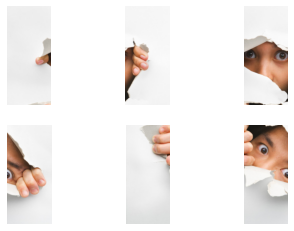

In [6]:
DATA_PATHS = [
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_3.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_5.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_10.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_30.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_2_50.pkl',
    '../data/shred/depositphotos_11056146-stock-photo-two-peeking-from-hole-in_4_50.pkl',
]

data = load_data(DATA_PATHS[0])
imshow(data.images, data.rows, data.cols)

In [7]:
def values(x):
    return np.vectorize(lambda x: x.value())(x)

def show_solution(data, x):
    x_idx = np.array(np.where(values(x) == 1.)).T
    imshow(
        [data.images[a] for a, i, j in sorted(x_idx, key=lambda v: v[1]*data.cols + v[2])],
        data.rows,
        data.cols
    )

--- data: rows=2, cols=3 ---
	elapsed_time(s)=0.04625678062438965
	cost=-2080.0
	state=Optimal


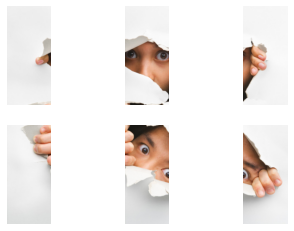

--- data: rows=2, cols=5 ---
	elapsed_time(s)=26.9023175239563
	cost=-3070.0
	state=Optimal


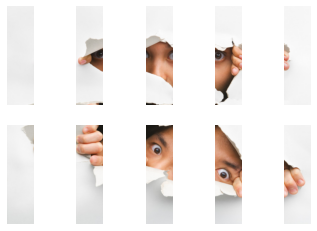

--- data: rows=4, cols=5 ---
	elapsed_time(s)=937.731386423111
	cost=-4126.0
	state=Optimal


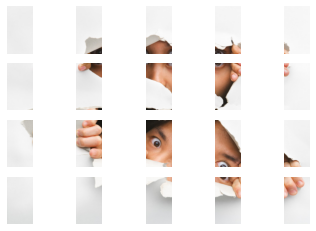

--- data: rows=2, cols=10 ---
	elapsed_time(s)=1036.3044662475586
	cost=-6340.0
	state=Optimal


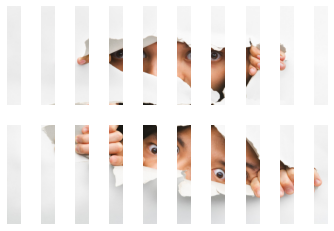

PulpSolverError: Pulp: Error while trying to execute, use msg=True for more details/home/mitsuhisa.ohta/projects/shredder_challenge/.venv/lib/python3.6/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc

In [8]:
if pulp.GUROBI_CMD().available():
    solver = pulp.GUROBI_CMD()
else:
    solver = pulp.PULP_CBC_CMD(timeLimit=2*60*60, threads=multiprocessing.cpu_count())

for data_path in DATA_PATHS:
    data = load_data(data_path)
    model, x = build_model(data)
    start = time.time()
    status = solver.solve(model)
    elapsed_time = time.time() - start

    print(f'--- data: rows={data.rows}, cols={data.cols} ---')
    print(f'\telapsed_time(s)={elapsed_time}')
    print(f'\tcost={model.objective.value()}')
    print(f'\tstate={pulp.LpStatus[status]}')

    show_solution(data, x)
    plt.show()

    if elapsed_time > 30*60:
        break